In [1]:
import git
import pandas as pd
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danyu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#! git clone https://github.com/Thiag0car/Costume-Trends-Scraper

In [3]:
df = pd.read_csv(r"C:\Users\danyu\Documents\Trabalho_Savino\Costume-Trends-Scraper\Costume-Trends-Scraper\Redes Sociais Scraping\textos_redes_sociais_novo.csv")

In [4]:
df.head()

,Texto,Data,Redes Sociais,sentimento
0,O SÃO JOÃO ARRUMOU UMA GIRL EM PLENA FESTA JUNINA,2023-06-22 08:23 AM,twitter.com,Negative
1,babando na minha bebêzinha com lenço de festa ...,2023-06-22 08:23 AM,twitter.com,Positive
2,MDS!!! Tem quentão? Amooooo 🫶,2023-06-22 08:23 AM,twitter.com,Positive
3,eh pq eh tema de festa junina,2023-06-22 08:22 AM,twitter.com,Neutral
4,Me segurando com todas as minhas forças pra nã...,2023-06-22 08:22 AM,twitter.com,Neutral


In [5]:
df['Redes Sociais'].unique()

array(['twitter.com', 'abrasce.com.br', 'campograndenews.com.br', ...,
       'folhadeoliveira.blogspot.com', 'algarveinformativo.blogspot.com',
       'barradorochanews.com.br'], dtype=object)

# Pyspark

### Bibliotecas

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import explode, regexp_replace

<img src="https://alphatradu.com.br/wp-content/uploads/2017/11/logos-redes-sociais-gratis-4.png" alt="Descrição da imagem" width="500" height="300" style="float: center;">

### Contagem de palavras: Redes Sociais
- Selecionando as principais palavras;
- Aplicando Stopwords;
- Aplicando filtros para caracteres indesejados

In [7]:
spark = SparkSession.builder.getOrCreate()

stopwords_list = nltk_stopwords.words('portuguese')
custom_stopwords = ['[...]', '...', ' ', '',  '-', 'pra', 'ano', '1', 'vai', '–', 'além']
stopwords_list.extend(custom_stopwords)

df = spark.read.csv(r"C:\Users\danyu\Documents\Trabalho_Savino\Costume-Trends-Scraper\Costume-Trends-Scraper\Redes Sociais Scraping\textos_redes_sociais_novo.csv", header=True)

df = df.withColumn("Texto", (regexp_replace("Texto", "[,#]", "")))
tokenizer = Tokenizer(inputCol="Texto", outputCol="words")
df = tokenizer.transform(df)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stopwords_list)
df = remover.transform(df)

df = df.select(explode("filtered_words").alias("word"))
word_counts = df.groupby("word").count().orderBy("count", ascending=False)

word_counts.show(30)


+-----------+-----+
|       word|count|
+-----------+-----+
|      festa| 6989|
|     junina| 5784|
|      milho| 1477|
|    pamonha| 1425|
|      junho| 1197|
|    quentão| 1091|
|       joão|  985|
|        dia|  891|
|    comidas|  885|
|    típicas|  851|
|    canjica|  688|
|     evento|  666|
|     festas|  662|
|festajunina|  639|
|       bolo|  633|
|tradicional|  596|
|      fazer|  589|
|    juninas|  553|
|     xadrez|  528|
|     arraiá|  515|
|     camisa|  500|
|    saojoao|  486|
|      forró|  477|
|        mês|  475|
|    durante|  471|
|     grande|  429|
|      muita|  421|
|     sábado|  416|
|       dias|  391|
|    receita|  390|
+-----------+-----+
only showing top 30 rows



# WordCloud das palavras principais 

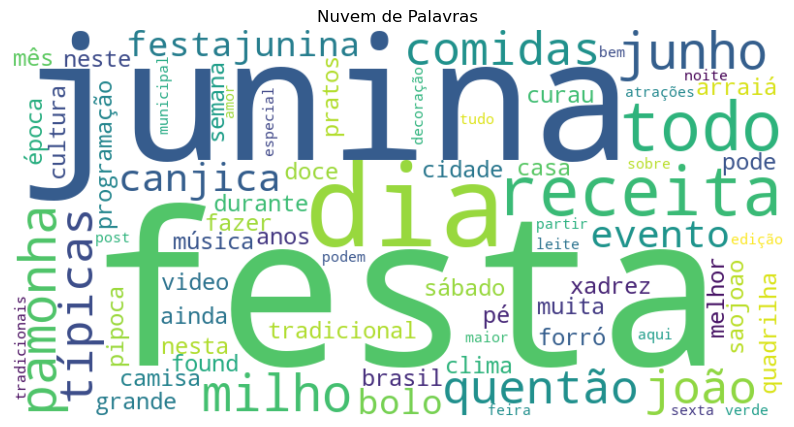

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text_cloud = ' '.join([row['word'] for row in word_counts.limit(80).collect()])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_cloud)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras')
plt.show()

## Criando um Dataframe com as 15 palavras mais frequentes e suas respectivas contagens

In [9]:
from pyspark.sql.functions import desc, col, sum as sql_sum

spark = SparkSession.builder.getOrCreate()

top_15 = word_counts.limit(16).collect()

specific_words = [row.word for row in top_15]

df = spark.read.csv(r"C:\Users\danyu\Documents\Trabalho_Savino\Costume-Trends-Scraper\Costume-Trends-Scraper\Redes Sociais Scraping\textos_redes_sociais_novo.csv", header=True)

df = df.filter(df["Texto"].isNotNull() & df["Redes Sociais"].isNotNull())

tokenizer = Tokenizer(inputCol="Texto", outputCol="words")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

df = df.select(explode("filtered_words").alias("word"), col("Redes Sociais"))

df_specific_words = df.filter(col("word").isin(specific_words))

word_counts = df_specific_words.groupby("Redes Sociais").pivot("word").count().na.fill(0)

pandas_df = word_counts.toPandas()

pandas_df = pandas_df.rename(columns={"'Redes Sociais'": "Nome das redes", "total_words": "Soma palavras relevantes"})

pandas_df["Soma palavras relevantes"] = pandas_df.sum(axis=1)
pandas_df = pandas_df.sort_values("Soma palavras relevantes", ascending=False)

df_redes = pandas_df.head(10).reset_index(drop=True)


C:\Users\danyu\AppData\Local\Temp\ipykernel_18196\3443763588.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pandas_df["Soma palavras relevantes"] = pandas_df.sum(axis=1)


In [10]:
df_redes

,Redes Sociais,bolo,canjica,comidas,dia,evento,festa,festas,joão,junho,junina,milho,pamonha,quentão,tradicional,típicas,Soma palavras relevantes
0,twitter.com,38,14,10,42,8,456,21,30,19,347,69,90,95,2,3,1244
1,youtube.com,33,8,15,24,1,205,21,26,16,130,114,68,68,14,10,753
2,tiktok.com,4,2,1,19,0,101,15,49,5,78,34,26,14,1,1,350
3,terra.com.br,4,5,6,4,3,83,10,5,5,56,26,8,8,3,6,232
4,noticias.webanuncio.com.br,1,0,5,1,5,64,6,8,7,54,3,4,1,7,5,171
5,awebic.com,1,0,5,0,0,55,9,39,0,43,2,2,1,0,3,160
6,medconst.blogspot.com,0,0,4,1,3,63,10,6,5,45,0,0,1,1,1,140
7,paranashop.com.br,2,1,8,12,12,20,5,0,3,13,4,2,6,3,5,96
8,jornaltribuna.com.br,4,0,1,4,2,23,4,10,1,19,5,3,5,4,5,90
9,davidgomesbalancas.wordpress.com,0,0,2,1,0,25,3,1,0,17,11,8,5,7,1,81


### Exportando dataframe em csv

In [11]:
#pandas_df.to_csv(r"C:\Users\danyu\Desktop\Resultados_df/Redes.csv", index=False)

<img src="https://img.freepik.com/vetores-premium/icone-do-globo-com-efeito-gradiente-roxo_197792-4858.jpg" alt="Descrição da imagem" width="300" height="500" style="float: center;">

### Contagem de palavras: Sites
- Selecionando as principais palavras;
- Aplicando Stopwords;
- Aplicando filtros para caracteres indesejados

In [12]:
df_sites = pd.read_csv(r"C:\Users\danyu\Documents\Trabalho_Savino\Costume-Trends-Scraper\web_scrapping\dados_sites.csv")

In [13]:
df_sites

,url,texto
0,https://blog.wpensar.com.br/pedagogico/como-ab...,Produtos Gestão Escolar Captação d...
1,https://www.fazfacil.com.br/artesanato/festa-j...,Entrar Decoração Artesanato Jardim Ref...
2,https://www.guiadasemana.com.br/na-cidade/noti...,× Home Sobre nós Contato Pesquise e nav...
3,https://all.accor.com/pt-br/brasil/magazine/on...,All: Accor Live Limitless Menu Hospedagem Vo...
4,https://www.df.senac.br/faculdade/origem-da-fe...,Seja bem-vindo ao blog da Faculdade! ...
...,...,...
1028,https://guia.folha.uol.com.br/restaurantes/202...,Logo da Folha de S.Paulo Folha de S. Paulo ...
1029,https://guia.folha.uol.com.br/shows/2023/05/fe...,Logo da Folha de S.Paulo Folha de S. Paulo ...
1030,https://guia.folha.uol.com.br/guloseimas/98135...,Logo da Folha de S.Paulo Folha de S. Paulo ...
1031,https://guia.folha.uol.com.br/restaurantes/202...,Logo da Folha de S.Paulo Folha de S. Paulo ...


### Agrupando sites por domínio

In [14]:
from urllib.parse import urlparse

In [15]:
df_sites['Domínio'] = df_sites['url'].apply(lambda x: urlparse(x).netloc)
df_sites.drop('url', axis=1, inplace=True)

In [16]:
df_sites

,texto,Domínio
0,Produtos Gestão Escolar Captação d...,blog.wpensar.com.br
1,Entrar Decoração Artesanato Jardim Ref...,www.fazfacil.com.br
2,× Home Sobre nós Contato Pesquise e nav...,www.guiadasemana.com.br
3,All: Accor Live Limitless Menu Hospedagem Vo...,all.accor.com
4,Seja bem-vindo ao blog da Faculdade! ...,www.df.senac.br
...,...,...
1028,Logo da Folha de S.Paulo Folha de S. Paulo ...,guia.folha.uol.com.br
1029,Logo da Folha de S.Paulo Folha de S. Paulo ...,guia.folha.uol.com.br
1030,Logo da Folha de S.Paulo Folha de S. Paulo ...,guia.folha.uol.com.br
1031,Logo da Folha de S.Paulo Folha de S. Paulo ...,guia.folha.uol.com.br


In [17]:
#df_sites.to_csv(r"C:\Users\danyu\Desktop\Resultados_df/Sites_filtro.csv", index=False)

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from urllib.parse import urlparse
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import explode

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(r"C:\Users\danyu\Desktop\Resultados_df/Sites_filtro.csv", header=True)

df = df.filter(df["texto"].isNotNull())

tokenizer = Tokenizer(inputCol="texto", outputCol="words")
df = tokenizer.transform(df)

stopwords_list = nltk_stopwords.words('portuguese')
custom_stopwords = ['in', 'faça', 'saiba', 'the', ',', '2023', '',  '-', 'sobre', '|', 'leia', 'duvidas', '–', 'to', 'fyp', '.', '·', 'folha', 'veja', 'paulo', 'logo']
stopwords_list.extend(custom_stopwords)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stopwords_list)
df = remover.transform(df)

df = df.select(explode("filtered_words").alias("word"))

word_counts = df.groupby("word").count().orderBy("count", ascending=False)

word_counts.show(30, truncate=False)

+------------+-----+
|word        |count|
+------------+-----+
|exercícios  |7941 |
|festa       |4894 |
|enem        |4747 |
|dúvidas     |3573 |
|sp          |3414 |
|shows       |3337 |
|brasil      |3165 |
|junina      |3147 |
|dia         |2911 |
|história    |2806 |
|dicas       |2726 |
|salvar      |2508 |
|passeios    |2394 |
|fazer       |2383 |
|festas      |2308 |
|restaurantes|2246 |
|guia        |2055 |
|instagram   |2011 |
|melhor      |1948 |
|videoaulas  |1945 |
|carnaval    |1937 |
|assine      |1935 |
|pode        |1879 |
|artigos     |1825 |
|saúde       |1775 |
|confira     |1673 |
|decoração   |1652 |
|moda        |1629 |
|política    |1622 |
|física      |1608 |
+------------+-----+
only showing top 30 rows



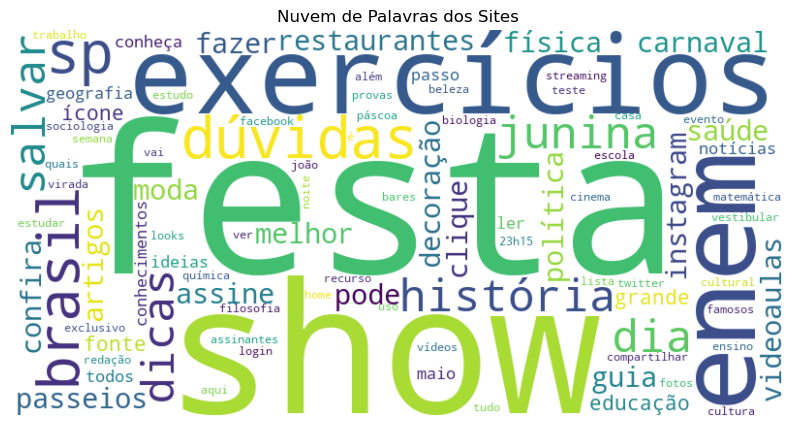

In [19]:
text_cloud = ' '.join([row['word'] for row in word_counts.limit(100).collect()])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_cloud)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Sites')
plt.show()

In [20]:
spark = SparkSession.builder.getOrCreate()

top_15_words = word_counts.limit(16).collect()

specific_words = [row.word for row in top_15_words]

df = spark.read.csv(r"C:\Users\danyu\Desktop\Resultados_df/Sites_final.csv", header=True)

df = df.filter(df["texto"].isNotNull() & df["Domínio"].isNotNull())

tokenizer = Tokenizer(inputCol="texto", outputCol="words")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

df = df.select(explode("filtered_words").alias("word"), col("Domínio"))

df_specific_words = df.filter(col("word").isin(specific_words))

word_counts = df_specific_words.groupby("Domínio").pivot("word").count().na.fill(0)

pandas_df = word_counts.toPandas()

pandas_df = pandas_df.rename(columns={"Domínio": "Sites", "total_words": "Soma palavras relevantes"})

pandas_df["Soma palavras relevantes"] = pandas_df.sum(axis=1)
pandas_df = pandas_df.sort_values("Soma palavras relevantes", ascending=False)

df_sites = pandas_df.head(15).reset_index(drop=True)


C:\Users\danyu\AppData\Local\Temp\ipykernel_18196\3253331850.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pandas_df["Soma palavras relevantes"] = pandas_df.sum(axis=1)


In [21]:
df_sites

,Sites,brasil,dia,dicas,dúvidas,enem,exercícios,fazer,festa,festas,história,junina,passeios,restaurantes,salvar,shows,sp,Soma palavras relevantes
0,the cookies that are categorized as necessary...,178,1423,1299,5,0,12,1507,3590,1854,359,2247,0,0,90,559,18,13141
1,guia.folha.uol.com.br,56,543,316,34,0,0,87,94,32,26,68,1781,1712,0,1608,2452,8809
2,exercicios.brasilescola.uol.com.br,246,4,7,31,34,5926,5,0,0,158,0,0,0,0,0,1,6412
3,brasilescola.uol.com.br,475,114,149,954,794,542,52,54,3,575,49,0,0,0,1,1,3763
4,vestibular.brasilescola.uol.com.br,209,51,282,112,1837,53,135,0,3,12,0,0,0,0,0,0,2694
5,blog.xalingo.com.br,9,20,64,3,0,0,93,83,32,2,41,0,0,0,0,0,347
6,www.sympla.com.br,38,25,1,14,0,0,16,83,48,1,17,46,1,0,47,6,343
7,please provide us the address When the tra...,312,5,0,0,0,1,2,3,3,1,0,0,0,0,7,0,334
8,monografias.brasilescola.uol.com.br,88,6,1,18,18,18,10,0,0,46,0,0,0,0,0,2,207
9,educador.brasilescola.uol.com.br,33,3,46,15,18,9,3,0,0,54,0,0,0,0,0,0,181


In [22]:
#df_sites.to_csv(r"C:\Users\danyu\Desktop\Resultados_df/Sites_vfinal.csv", index=False)